<a href="https://colab.research.google.com/github/iloveleejunghyun/CMPE257-Team-Project/blob/master/CMPE257_TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/iloveleejunghyun/CMPE257-Team-Project/master/reduce3.csv

--2020-12-01 00:57:52--  https://raw.githubusercontent.com/iloveleejunghyun/CMPE257-Team-Project/master/reduce3.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73578087 (70M) [text/plain]
Saving to: ‘reduce3.csv’

reduce3.csv         100%[===================>]  70.17M   204MB/s    in 0.3s    

2020-12-01 00:57:55 (204 MB/s) - ‘reduce3.csv’ saved [73578087/73578087]



In [ ]:

import numpy as np
import pandas as pd
import collections
#Number of dataset to use
N = 10000
least_fre = 2
#How many keys to use
max_sel_keys = 500

In [ ]:
%%time

df = pd.read_csv("reduce3.csv")

# get ingredients_text where Location = USA
df =  df.query("countries_en == 'United States'")

ing_list = collections.defaultdict(int)
total = df.shape[0]
N = min(total, N)



df = df[0:N]

print("dataset size",total)
print("used ",N)


for i in range (N):
    ingredients_text = df.iat[i,2]
    ing = ingredients_text.split(",")
    for j in range(len(ing)):
        ing[j] = ing[j].replace(".","").replace(")","").replace("(","").strip().lower()
       
    for ingredient in ing:
        ing_list[ingredient] += 1

print("key size", len(ing_list))
total_count = 0
for val in ing_list.values():
    total_count += val
print("total frequency count", total_count)

max_sel_keys = min(max_sel_keys, len(ing_list))
print(f"There are too many keys, we only use top {max_sel_keys} frequent keys to cluster")

count_dict = collections.defaultdict(list)
for key, val in ing_list.items():
    if val >= least_fre:
        count_dict[val].append(key)

counts = list(count_dict.keys())
counts.sort(reverse=True)
sel_keywords = set()
selected_count = 0
key_fre = []
for i in range(min(max_sel_keys, len(counts))):
    # print(f"count={counts[i]}, ingredients={count_dict[counts[i]]}")
    sel_keywords |= set(count_dict[counts[i]])
    selected_count += counts[i]
    for ingredient in count_dict[counts[i]]:
        key_fre.append([ingredient, counts[i]])

key_fre = pd.DataFrame(key_fre, columns=["ingredient", "frequency"])

print("total keys", len(ing_list))
# print("selected key list", sel_keywords)
print("selected key frequency count", selected_count)
print(key_fre)

# add columns
for item in sel_keywords:
    df[item] = 0 #init with 0

for i in range (N):
    ingredients_text = df.iat[i,2]
    ing = ingredients_text.split(",")
    for j in range(len(ing)):
        ing[j] = ing[j].replace(".","").strip()
    for ingredient in ing:
        if ingredient in sel_keywords:
            df.at[i,ingredient] = 1

df = df[0:N]

# df.to_csv("highDdata.csv", index = False)



dataset size 171460
used  10000
key size 14689
total frequency count 115725
There are too many keys, we only use top 500 frequent keys to cluster
total keys 14689
selected key frequency count 64156
                     ingredient  frequency
0                          salt       6248
1                         sugar       4280
2                         water       3728
3                   citric acid       1974
4                        niacin       1386
...                         ...        ...
5443          selected potatoes          2
5444        white and green tea          2
5445  green coffee bean extract          2
5446       guarana seed extract          2
5447           tbhq antioxidant          2

[5448 rows x 2 columns]
CPU times: user 18 s, sys: 826 ms, total: 18.8 s
Wall time: 18.9 s


In [ ]:
%%time
# 2n part, cluster
import numpy as np
import pandas as pd
import collections
from sklearn.cluster import KMeans

N = df.shape[0]
df = df.reset_index(drop=True)
print("dataset size", N)
df = df[0:N+1]
data = np.array(df)
data = data[:, 6:data.shape[1]]
# print(data)
 
num_clusters = 2
km_cluster = KMeans(n_clusters=num_clusters, max_iter=300, n_init=10, \
                    init='k-means++',n_jobs=1)


result = km_cluster.fit_predict(data)
show = np.column_stack((np.array(df)[:,1], result))
show = pd.DataFrame(show, columns=["name", "label"])
print(show)

def count_cluster(arr):
    return np.sum(arr)
count_c1 = count_cluster(result)
count_c0 = len(result) - count_c1
print("count of cluter0", count_c0)
print("count of cluter1", count_c1)

result = pd.DataFrame(result, columns=["label"])
result = pd.concat([df, result], axis=1)


# result.to_csv("highDdataLabeled.csv", index = False)
# res = km_cluster.predict(data)
# print(res)
# for i in range(N):
#     print(df.iat[i,1], result[i])







dataset size 10000
               name label
0     United States     1
1     United States     1
2     United States     1
3     United States     1
4     United States     1
...             ...   ...
9995  United States     1
9996  United States     1
9997  United States     1
9998  United States     1
9999  United States     1

[10000 rows x 2 columns]
count of cluter0 1350
count of cluter1 8650
CPU times: user 25.3 s, sys: 2.44 s, total: 27.7 s
Wall time: 26.3 s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  """


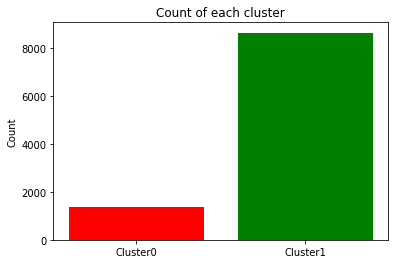

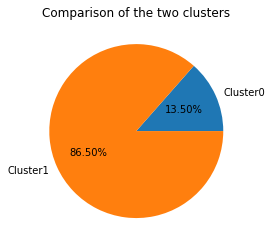

In [ ]:
import matplotlib.pyplot as plt
 
name_list = ['Cluster0','Cluster1']
num_list = [count_c0, count_c1]
plt.bar(range(len(num_list)), num_list,color='rgb',tick_label=name_list)
plt.ylabel("Count")
plt.title("Count of each cluster")
plt.show()


plt.pie(num_list,labels=name_list,autopct='%1.2f%%') #画饼图（数据，数据对应的标签，百分数保留两位小数点）
plt.title("Comparison of the two clusters")
plt.show()

In [ ]:
#part3, prediction

In [ ]:
%%time
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

#read data
# df = pd.read_csv("highDdataLabeled.csv")
df = result
y = df[["label"]]
X = df.iloc[:,5:df.shape[1]-1]

def err_count(y, pred_y):
    return np.sum(y != pred_y)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
y_train = y_train.squeeze()
y_test = y_test.squeeze()

CPU times: user 233 ms, sys: 1.96 ms, total: 235 ms
Wall time: 246 ms


In [ ]:
%%time
# MLP

# print(x_train.shape)
# print(y_train.shape)
#try different parameters
#PSO
clf = MLPClassifier(solver="lbfgs", alpha=1e-5, hidden_layer_sizes=(5,2), random_state=1)

clf.fit(X_train,y_train)
pred_y = clf.predict(X_train)
Ein_MLP = err_count(y_train, pred_y)
Ein_MLP = Ein_MLP / y_train.shape[0]
print("Ein_MLP", Ein_MLP)

clf.fit(X_test,y_test)
pred_y = clf.predict(X_test)
tEin_MLP = err_count(y_test, pred_y)
tEin_MLP = tEin_MLP / y_test.shape[0]
print("tEin_MLP", tEin_MLP)

Ein_MLP 0.132875
tEin_MLP 0.1435
CPU times: user 2.87 s, sys: 174 ms, total: 3.04 s
Wall time: 1.63 s


In [ ]:
%%time
#SVM
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train,y_train)

pred_y = clf.predict(X_train)
Ein_SVM = err_count(y_train, pred_y)
Ein_SVM = Ein_SVM
print("Ein_SVM", Ein_SVM)

clf.fit(X_test,y_test)
pred_y = clf.predict(X_test)
tEin_SVM = err_count(y_test, pred_y)
tEin_SVM = tEin_SVM
print("tEin_SVM", tEin_SVM)


Ein_SVM 4
tEin_SVM 0
CPU times: user 2min 5s, sys: 155 ms, total: 2min 5s
Wall time: 2min 5s


In [ ]:
%%time
#Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)

pred_y = clf.predict(X_train)
Ein_RF = err_count(y_train, pred_y)
Ein_RF = Ein_RF
print("Ein_RF", Ein_RF)

clf.fit(X_test,y_test)
pred_y = clf.predict(X_test)
tEin_RF = err_count(y_test, pred_y)
tEin_RF = tEin_RF
print("tEin_RF", tEin_RF)


Ein_RF 1063
tEin_RF 287
CPU times: user 948 ms, sys: 20.7 ms, total: 969 ms
Wall time: 1.04 s


In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

# X, y = load_iris(return_X_y=True)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
clf = GaussianNB()
pred_y = clf.fit(X_train, y_train)

pred_y = clf.predict(X_train)
Ein_Bayes = err_count(y_train, pred_y)
Ein_Bayes = Ein_Bayes
print("Ein_Bayes", Ein_Bayes)

clf.fit(X_test,y_test)
pred_y = clf.predict(X_test)
tEin_Bayes = err_count(y_test, pred_y)
tEin_Bayes = tEin_Bayes
print("tEin_Bayes", tEin_Bayes)


# print("Number of mislabeled points out of a total %d points : %d"
#       % (X_test.shape[0], (y_test != y_pred).sum()))

Ein_Bayes 3115
tEin_Bayes 569


[1.32875e-05, 0.0004, 0.1063, 0.3115]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


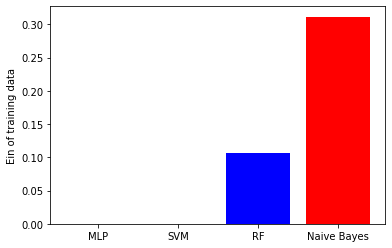

In [ ]:
#Comparison of Ein

import matplotlib.pyplot as plt
 
name_list = ['MLP','SVM',"RF", "Naive Bayes"]
num_list = [Ein_MLP/N, Ein_SVM/N,Ein_RF/N, Ein_Bayes/N]
print(num_list)
plt.bar(range(len(num_list)), num_list,color='rgb',tick_label=name_list)
plt.ylabel("Ein of training data")
plt.show()

[1.4349999999999998e-05, 0.0, 0.0287, 0.0569]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  


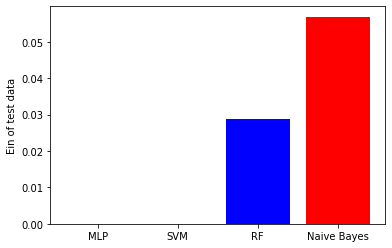

In [ ]:
# test set
# test train split
import matplotlib.pyplot as plt
 
name_list = ['MLP','SVM',"RF", "Naive Bayes"]
num_list = [tEin_MLP/N, tEin_SVM/N, tEin_RF/N, tEin_Bayes/N]
print(num_list)
plt.bar(range(len(num_list)), num_list,color='rgb',tick_label=name_list)
plt.ylabel("Ein of test data")
plt.show()